# Code

## Packages

In [2]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import random

## Parameters

In [15]:
import easydict
 
args = easydict.EasyDict({
    "total_pop_num": 100000,  #total_population number
    "epi_length": 100000,  # episode length
    "a": 1/100,  # infection probability
    "b": 10,  # frequency of contact
    "delay_period": 4,  # period of infected to confirmed
    "remove_period": 1,  # period of confirmed to removed
    "bounded": True,  # bounded rationality or not
    "g_init_infected_num" : 1
    # Parameters related with groups
})


## Model

In [16]:
class corona_world(object):
    def __init__(self, args):
        # Parameters
        self.total_pop_num = args.total_pop_num
        self.epi_length = args.epi_length
        self.a = args.a
        
        self.b = args.b

        self.delay_period = args.delay_period
        self.remove_period = args.remove_period
        self.bounded = args.bounded
        self.g_init_infected_num = args.g_init_infected_num
        # Variables changed by time 
        self.g_pop = np.zeros([self.epi_length + 1, 4])  # [time, type(S, I, C, R)]
        self.g_pop_change = np.zeros([self.epi_length + 1, 4]) # daily change, [time, type(S, I, C, R)]
        
    def initialize_world(self):
        total_g_pop_num = self.total_pop_num 
        infected_g_pop_num = self.g_init_infected_num
        self.g_pop[0, 0] = (total_g_pop_num - infected_g_pop_num) / total_g_pop_num
        self.g_pop[0, 1] = infected_g_pop_num / total_g_pop_num

    def step(self, time):
        beta =  self.a * self.b
        
        # 당일 susceptible의 변화 / 당일의 activity에 따라 susceptible에서 infected로 가는 거 정의
        g_ds = - beta * self.g_pop[time-1,  1] * self.g_pop[time-1, 0] 
        
        # 당일 infected의 변화 / -g_ds만큼 더해지고 confirm되는 infected가 빠짐
        g_today_confirmed = 1 / self.delay_period * self.g_pop[time-1,  1]         
        g_di = - g_ds - g_today_confirmed
        
        # 당일 confirmed의 변화 / delay_period전 infected가 더해지고 전날 confirmed가 빠짐
        g_today_removed = 1 / self.remove_period * self.g_pop[time-1,  2]
        g_dc = g_today_confirmed - g_today_removed
        
        # 당일 removed의 변화 / 전날 confirmed가 더해짐
        g_dr = g_today_removed
        
        # g_pop의 변화
        self.g_pop[time,  0] = self.g_pop[time-1,  0] + g_ds
        self.g_pop[time,  1] = self.g_pop[time-1,  1] + g_di
        self.g_pop[time,  2] = self.g_pop[time-1,  2] + g_dc
        self.g_pop[time,  3] = self.g_pop[time-1,  3] + g_dr
        
        self.g_pop_change[time,  0] = g_ds
        self.g_pop_change[time,  1] = g_di
        self.g_pop_change[time,  2] = g_dc
        self.g_pop_change[time,  3] = g_dr
    
    def run(self):
        self.initialize_world()
        
        for j in range(self.epi_length):
            time = j + 1
            self.step(time)
            

In [52]:
class junyoung_world(object):
    def __init__(self, args):
        # Parameters
        self.total_pop_num = args.total_pop_num
        self.epi_length = args.epi_length
        self.a = args.a
        self.b = args.b
        self.bounded = args.bounded
        self.g_init_infected_num = args.g_init_infected_num
        self.list_beta=np.array([0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2])
        # Variables changed by time 
        self.g_pop = np.zeros([self.epi_length + 1, 15])  # [time, type(S, I, I, R)]
        self.g_pop_change = np.zeros([self.epi_length + 1, 15]) # daily change, [time, type(S, I, I, R)]
        self.total_infected=np.zeros([self.epi_length+1])
        
    def initialize_world(self):
        total_g_pop_num = self.total_pop_num 
        infected_g_pop_num = self.g_init_infected_num
        self.g_pop[0, 0] = (total_g_pop_num - infected_g_pop_num) / total_g_pop_num
        self.g_pop[0, 1] = infected_g_pop_num / total_g_pop_num
        self.total_infected[0]=0

    def step(self, time):
        beta =  self.a * self.b
        for i in range(13):
            self.total_infected[time-1]+=self.g_pop[time-1,i+1]
        
        # g_pop의 변화
        self.g_pop[time,  0] = self.g_pop[time-1,  0] - sum(self.list_beta * self.g_pop[time-1,1:14]) * self.g_pop[time-1, 0] 
        self.g_pop[time,  1] = sum(self.list_beta * self.g_pop[time-1,1:14]) * self.g_pop[time-1, 0] 
        for i in range(12):
            self.g_pop[time, i+2] = self.g_pop[time-1, i+1] 
        self.g_pop[time, 14] = self.g_pop[time-1, 14]+self.g_pop[time-1,13]
    
    def run(self):
        self.initialize_world()
        
        for j in range(self.epi_length):
            time = j + 1
            self.step(time)

In [14]:
aaa=np.array([15,14])
bbb=np.array([1,2])
aaa*bbb


array([15, 28])

## Run

In [1496]:
x = corona_world(args)
x.run()

In [54]:
y = junyoung_world(args)
y.run()

In [1498]:
#y2 = junyoung_world(args)
#y2.run()

In [1499]:
np.set_printoptions(precision=8, linewidth=np.inf)

# Plot

In [21]:
def plot_g_pop(world, period=1):
    plt.figure(figsize=(10, 7))
    
    plt.plot(world.g_pop[:period,  0], label='Susceptible')
    plt.plot(world.total_infected[:period], label='Infected')
    plt.plot(world.g_pop[:period,  14], label='Removed')

    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Proportion', fontsize=20)
    plt.legend(loc='lower right')
    plt.grid()
    
def plot_g_pop_sicr(world, period=0, state=0):
    plt.figure(figsize=(10, 7))
    
    if period == 0:
        plt.plot(world.g_pop[:, state ], label='i')
    else:
        plt.plot(world.g_pop[:period,  state ], label='In')
#     plt.ylim([0, 1])
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Proportion', fontsize=20)
    plt.legend(loc='lower right')
    plt.grid()

def plot_g(world, period=0):
    plt.figure(figsize=(10, 7))
    if period == 0:
        #plt.plot(world.g_pop[:,  0] * world.total_pop_num, label='Susceptible')
        plt.plot(world.g_pop[:,  1]* world.total_pop_num, label='Infected')
        plt.plot(world.g_pop[:,  2]* world.total_pop_num, label='Confirmed', color='green')
        #plt.plot(world.g_pop[:,  3]* world.total_pop_num, label='Removed')
        plt.plot(world.g_pop[:,  4]* world.total_pop_num, label='Unreported')
    else:
        #plt.plot(world.g_pop[:period,  0]* world.total_pop_num, label='Susceptible')
        plt.plot(world.g_pop[:period,  1]* world.total_pop_num, label='Infected')
        plt.plot(world.g_pop[:period,  2]* world.total_pop_num, label='Confirmed', color='green')
        #plt.plot(world.g_pop[:period,  3]* world.total_pop_num, label='Removed')
        plt.plot(world.g_pop[:period,  4]* world.total_pop_num, label='Unreported')
#     plt.ylim([0, 1])
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Total number', fontsize=20)
    plt.legend(loc='lower right')
    plt.grid()
    
def plot_g_sicr(world, period=0, state=0):
    plt.figure(figsize=(10, 7))
    
    if period == 0:
        plt.plot(world.g_pop[:, state ]* world.total_pop_num, label='i')
    else:
        plt.plot(world.g_pop[:period,  state ]* world.total_pop_num, label='Infected')
#     plt.ylim([0, 1])
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('# of total infected', fontsize=20)
    plt.legend(loc='lower right')
    plt.grid()
    
def plot_gullyuitsu(world, period=0):
    plt.figure(figsize=(10, 7))
    if period == 0:
        #plt.plot(world.g_pop[:,  0] * world.total_pop_num, label='Susceptible')
        #plt.plot(world.g_pop[:,  1]* world.total_pop_num, label='Infected')
        #plt.plot(world.g_pop[:,  2]* world.total_pop_num, label='Confirmed')
        #plt.plot(world.g_pop[:,  3]* world.total_pop_num, label='Removed')
        plt.plot(world.g_pop[:,  4]* world.total_pop_num +world.g_pop[:,  1]* world.total_pop_num, label='Gullyuitsu')
    else:
        #plt.plot(world.g_pop[:period,  0]* world.total_pop_num, label='Susceptible')
        #plt.plot(world.g_pop[:period,  1]* world.total_pop_num, label='Infected')
        #plt.plot(world.g_pop[:period,  2]* world.total_pop_num, label='Confirmed')
        #plt.plot(world.g_pop[:period,  3]* world.total_pop_num, label='Removed')
        plt.plot(world.g_pop[:period,  4]* world.total_pop_num+world.g_pop[:period,  1]* world.total_pop_num, label='Gullyuitsu',color='red')
#     plt.ylim([0, 1])
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Total number', fontsize=20)
    plt.legend(loc='lower right')
    plt.grid()

In [36]:
plot_g_sicr(x, 1000,1
          )

NameError: name 'x' is not defined

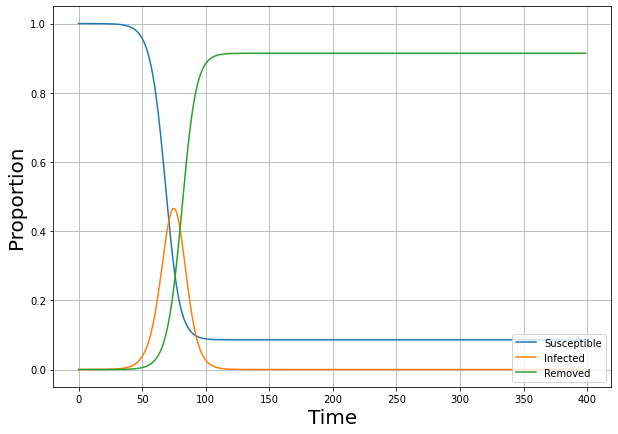

In [56]:
plot_g_pop(y, 400)

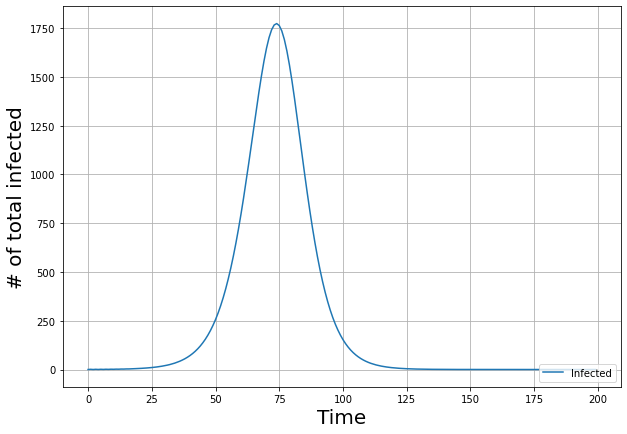

In [28]:
plot_g_sicr(y,200,2)

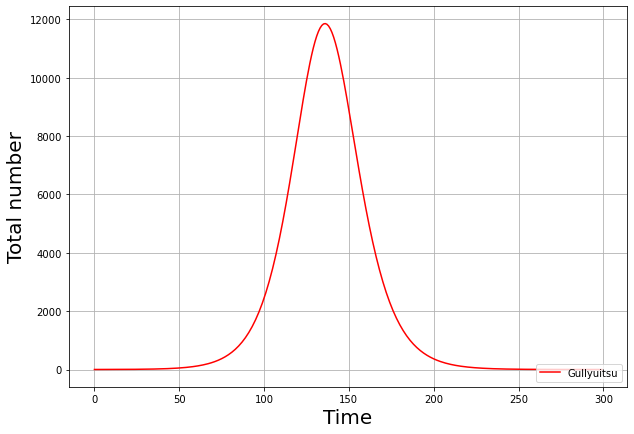

In [1504]:
plot_gullyuitsu(y, 300)

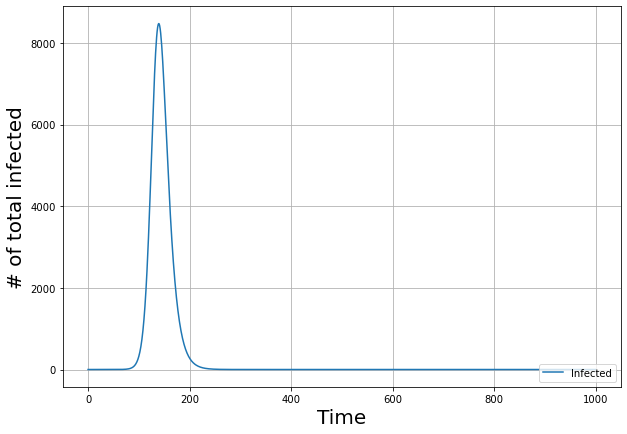

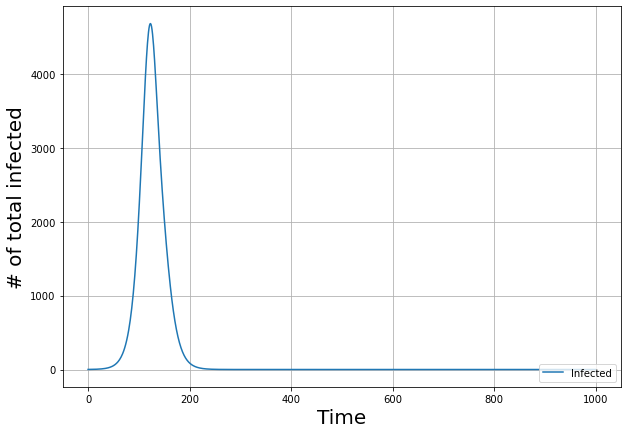

In [1505]:
plot_g_sicr(y,1000,4)
plot_g_sicr(y,1000,1)

In [1506]:
print(x.g_pop[1000][3]-x.g_pop[10000][3])
print(x.g_pop[1000])


0.0
[5.44591028e-01 6.42147381e-29 1.72437489e-29 4.55408972e-01]


Text(0, 0.5, 'p')

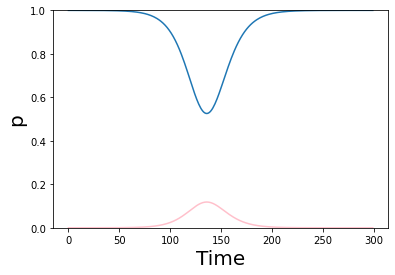

In [1507]:
plt.plot(y.portion_list[:300])
plt.ylim([0,1])
plt.plot(y.g_pop[:300,1]+y.g_pop[:300,4], color='pink')
plt.xlabel('Time', fontsize=20)
plt.ylabel('p', fontsize=20)

In [1508]:
y.portion_list

[0.99996,
 0.9999567067996,
 0.9999531424228416,
 0.9999492845464106,
 0.9999451090094061,
 0.9999405896621633,
 0.9999356982026483,
 0.9999304039994068,
 0.9999246738999615,
 0.9999184720234672,
 0.9999117595363319,
 0.9999044944094093,
 0.999896631155253,
 0.9998881205437993,
 0.999878909294716,
 0.9998689397445054,
 0.9998581494863018,
 0.9998464709801297,
 0.9998338311312144,
 0.999820150833736,
 0.9998053444772137,
 0.9997893194124733,
 0.9997719753739122,
 0.9997532038545093,
 0.9997328874297416,
 0.9997108990262658,
 0.9996871011308897,
 0.999661344935005,
 0.9996334694092692,
 0.9996033003029118,
 0.9995706490616002,
 0.9995353116573216,
 0.999497067323229,
 0.9994556771858508,
 0.9994108827864762,
 0.9993624044828978,
 0.9993099397220235,
 0.9992531611731443,
 0.9991917147108814,
 0.9991252172360114,
 0.9990532543215006,
 0.9989753776701462,
 0.9988911023692418,
 0.9987999039266394,
 0.998701215071477,
 0.9985944223016837,
 0.9984788621591466,
 0.9983538172121521,
 0.998218511